In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import IPython
IPython.core.display.set_matplotlib_formats('retina')
IPython.core.display.display_html(IPython.core.display.HTML("<style>img{image-rendering: pixelated}</style>"))

import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE

from utils import show_array, make_mosaic, unmake_mosaic, plot_images

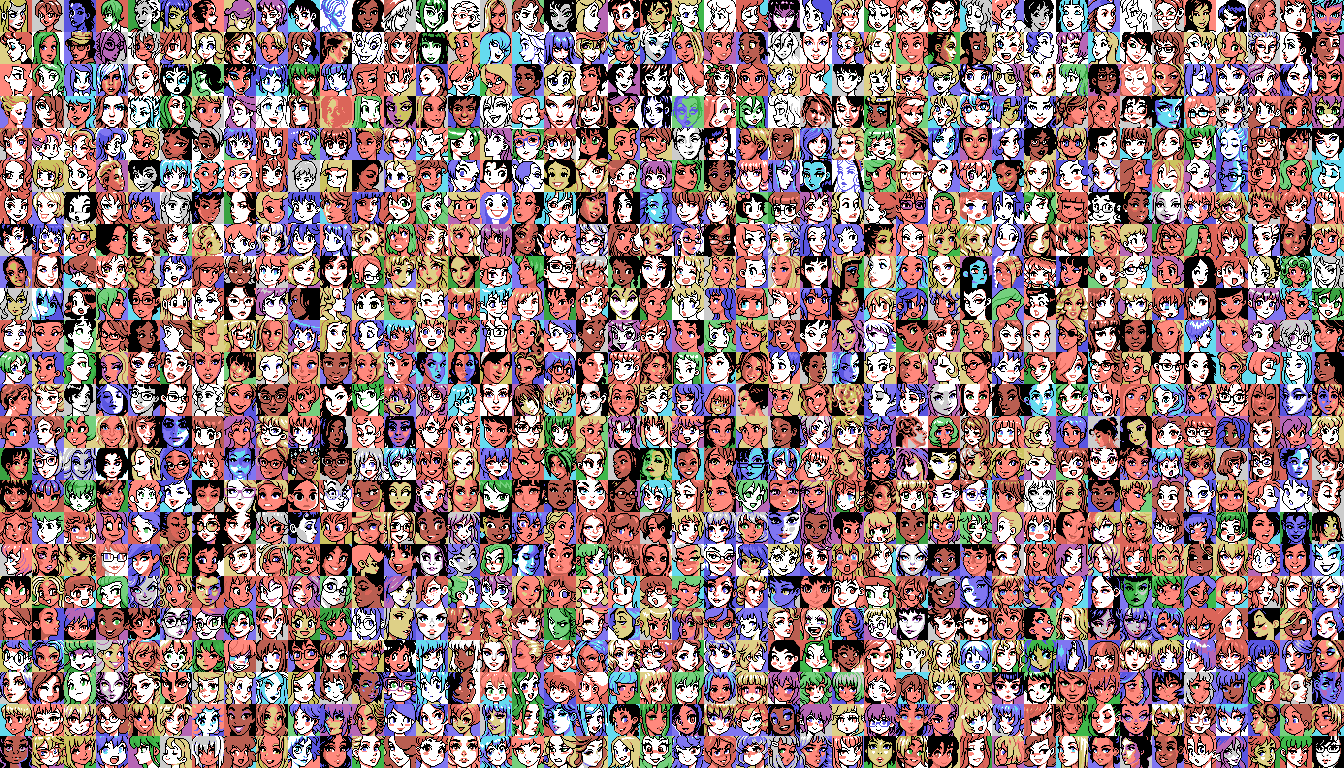

In [2]:
from skimage.io import imread
side = 32
img = imread('img.png')
img = img[:,:,:3] # drop alpha
show_array(img, retina=True)

In [3]:
images = unmake_mosaic(img, side)
tsne = TSNE(n_jobs=8)
%time Y = tsne.fit_transform(images.reshape(images.shape[0], -1).astype(np.float64))
Y -= Y.min(axis=0)
Y /= Y.max(axis=0)

CPU times: user 11.5 s, sys: 229 ms, total: 11.7 s
Wall time: 3.19 s


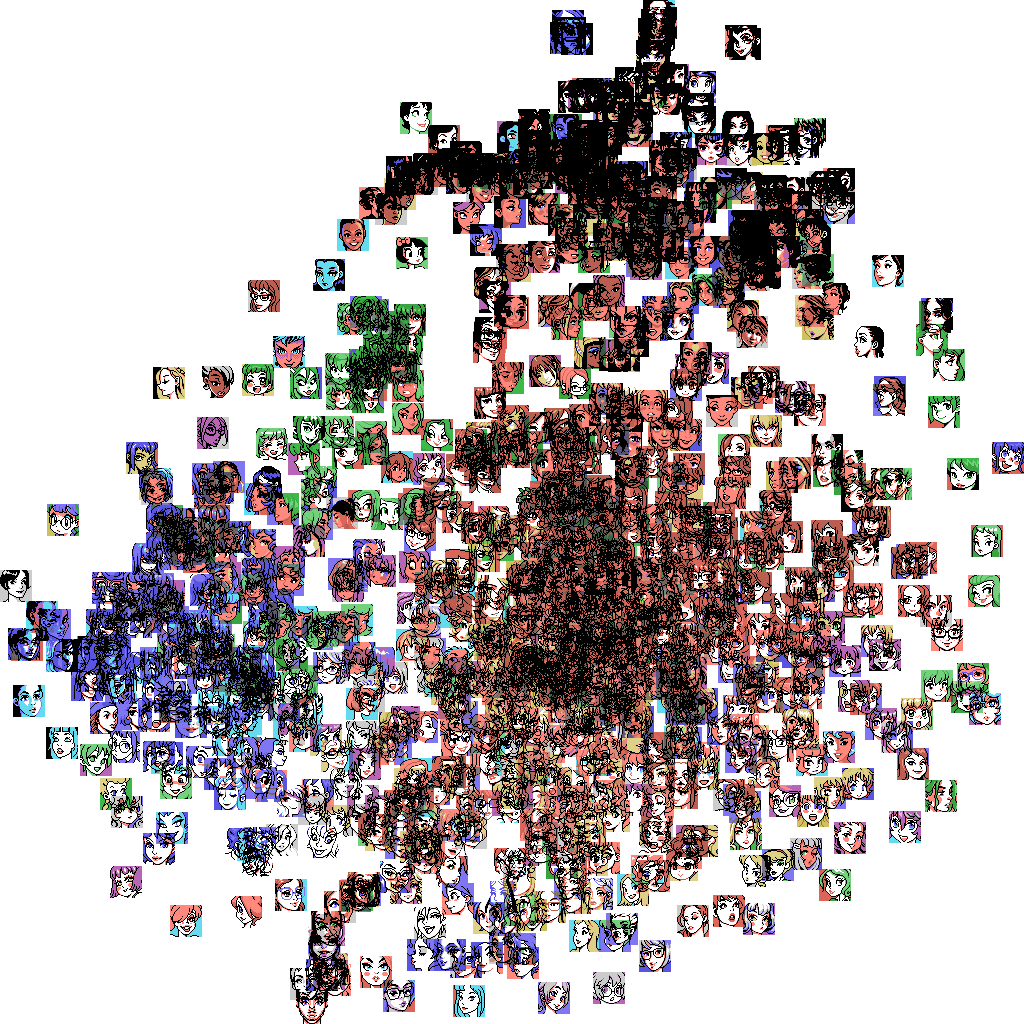

In [4]:
canvas = plot_images(images, Y, canvas_shape=(1024, 1024, 3), blend=np.minimum, fill=255)
show_array(canvas, retina=True)

CPU times: user 3.43 ms, sys: 2.57 ms, total: 6 ms
Wall time: 6.09 ms
CPU times: user 10.3 s, sys: 23.9 ms, total: 10.3 s
Wall time: 10.4 s


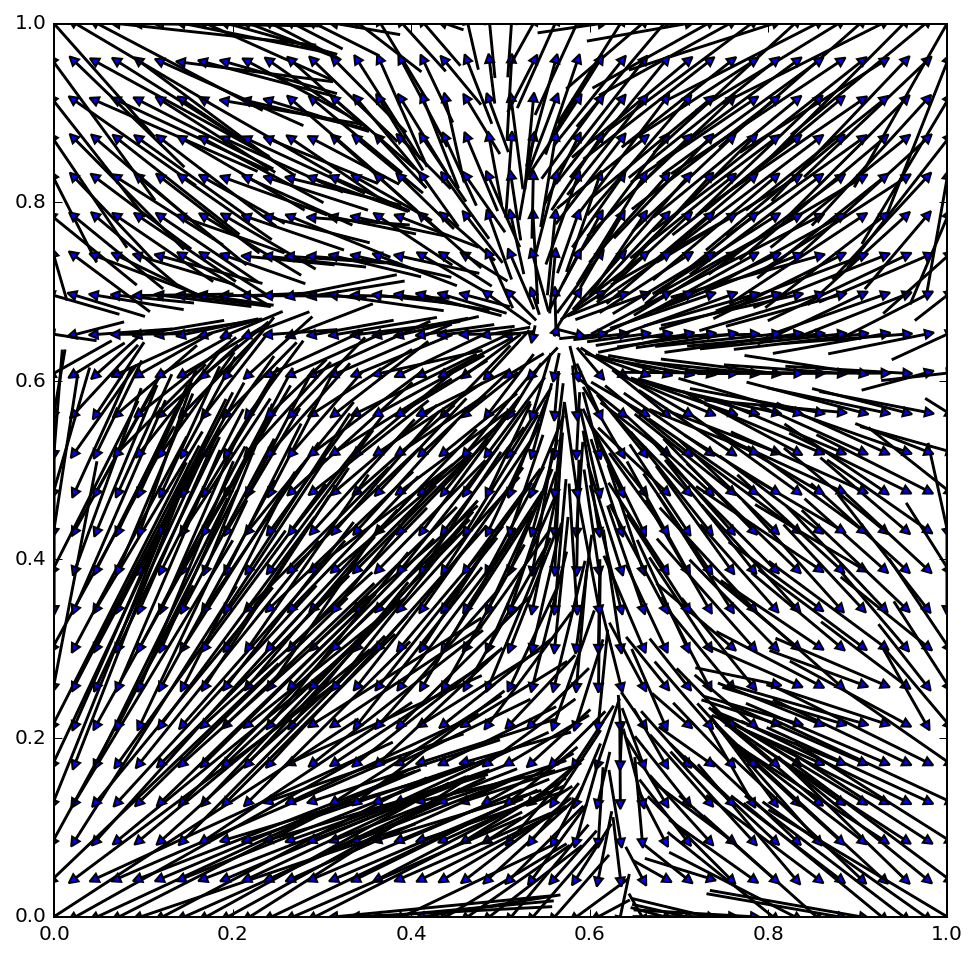

In [5]:
import LAPJV
from scipy.spatial.distance import cdist

nx = img.shape[1] / side
ny = img.shape[0] / side
xv, yv = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
grid = np.dstack((xv, yv)).reshape(-1, 2)
%time cost = cdist(grid, Y, 'sqeuclidean')
cost = cost * (100000. / cost.max())

totalDataPoints = nx * ny
%time min_cost,row_assigns,col_assigns,row_dual_vars,col_dual_vars = LAPJV.lap(cost)
grid_jv = grid[col_assigns[:totalDataPoints]]

plt.figure(figsize=(8, 8))
for start, end in zip(Y, grid_jv):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

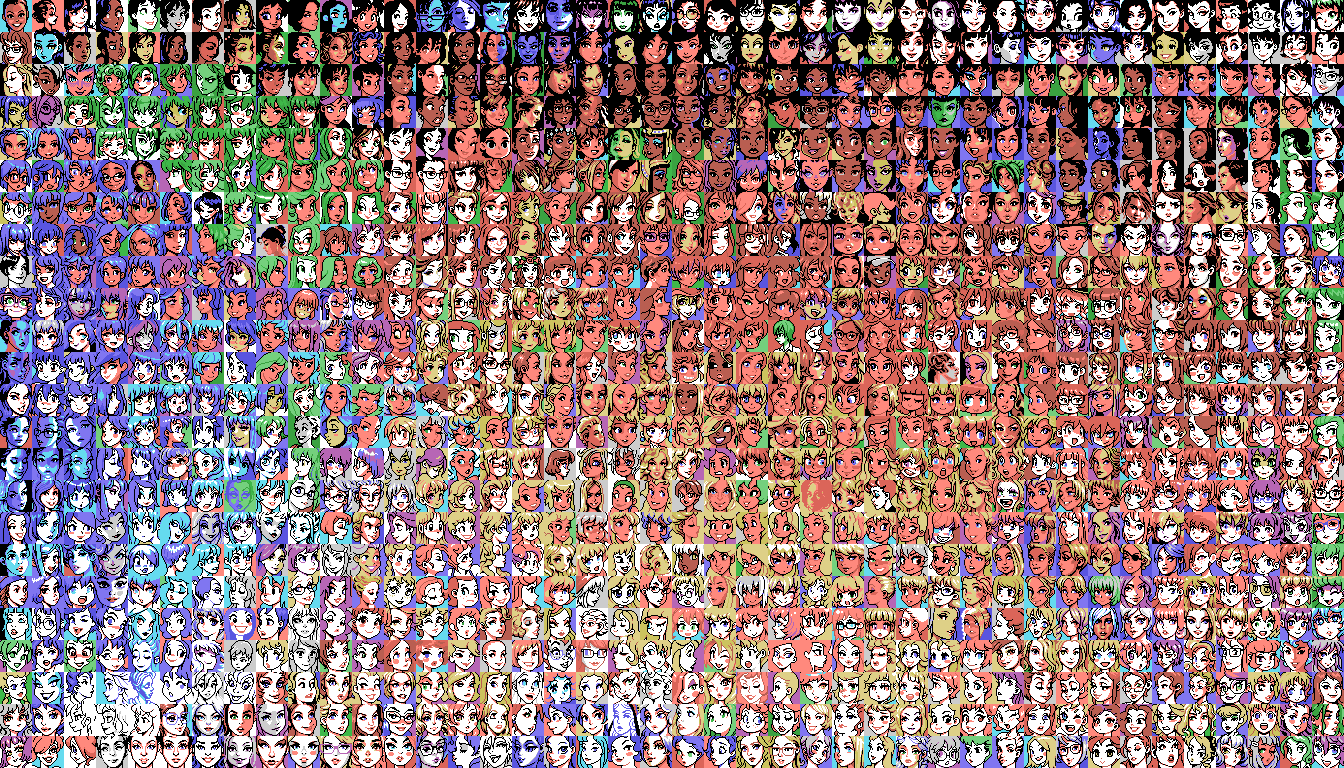

In [6]:
grid_tuples = [(y,x) for (x,y) in map(tuple, grid_jv)]
sorted_images = [image for (point, image) in sorted(zip(grid_tuples, images))]
mosaic = make_mosaic(sorted_images, nx=nx, ny=ny)
show_array(mosaic, retina=True)